# Introduction

A wide range of transformer-based models started coming up for different NLP tasks. There are multiple advantages of using transformer-based models, but the most important ones are:

## First Benefit

- These models do not process an input sequence token by token rather they take the entire sequence as input in one go which is a big improvement over RNN based models because now the model can be accelerated by the GPUs.

## 2nd Benefit

- We don’t need labeled data to pre-train these models. It means that we have to just provide a huge amount of unlabeled text data to train a transformer-based model. We can use this trained model for other NLP tasks like text classification, named entity recognition, text generation, etc. This is how transfer learning works in NLP.

BERT and GPT-2 are the most popular transformer-based models and in this article, we will focus on BERT and learn how we can use a pre-trained BERT model to perform text classification.

**Reference:**

- [Analyticsvidya Blog - starter code](https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/)
- [bert-sentiment - Abhishek Thakur](https://github.com/abhishekkrthakur/bert-sentiment/blob/master/train.py)


# Why finetune language model:

We often have large quantity of unlabelled dataset with only a small amount of labelled dataset.If we need to get accurate classification, we can use pretrained models trained on large corpus to get decent results. Generally, we use pretrained language models trained on large corpus to get embeddings and then mostly add a layer or two of neural networks on top to fit to our task in hand. This works very well until the data on which language model was trained is similar to our data. 

**Problem:** If our data is different than data used for pretraining, results would not be that satifactory. Consider for example if we have mix of Hindi and English language data and we are using pretrained model trained on Wikipedia, it would lead to bad results. 

**Solution:** In that scenario we need to fine-tune our language model too. As shown by Jeremy Howard and Sebastian Ruder in [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146), finetuning the language model can lead to performance enhancement. We generally modify the last few layers of language models to adapt to our data. This has been done and explained by Fast.ai in [Finetuning FastAI language model](https://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html). They have done it extensively for `ULMFit`. We can follow the same approach with Bert and other models. With the revolution in NLP world, and with the arrival of beasts such as Bert, OpenAI-GPT, Elmo and so on we need a library which could help us keep up with this growing pace in NLP. Here comes in Hugging Face pytorch-transformers, a one stop for NLP. This is easy to use library to meet all your NLP requirements written in Pytorch. We will see how we can fine-tune Bert language model and then use that for SequenceClassification all using pytorch-transformers.


# What is Model Fine-Tuning?

BERT (Bidirectional Encoder Representations from Transformers) is a big neural network architecture, with a huge number of parameters, that can range from 100 million to over 300 million. So, training a BERT model from scratch on a small dataset would result in overfitting.

So, it is better to use a pre-trained BERT model that was trained on a huge dataset, as a starting point. We can then further train the model on our relatively smaller dataset and this process is known as model fine-tuning.

## Different Fine-Tuning Techniques

- **Train the entire architecture** – We can further train the entire pre-trained model on our dataset and feed the output to a softmax layer. In this case, the error is back-propagated through the entire architecture and the pre-trained weights of the model are updated based on the new dataset.
- **Train some layers while freezing others** – Another way to use a pre-trained model is to train it partially. What we can do is keep the weights of initial layers of the model frozen while we retrain only the higher layers. We can try and test as to how many layers to be frozen and how many to be trained.
- **Freeze the entire architecture** – We can even freeze all the layers of the model and attach a few neural network layers of our own and train this new model. Note that the weights of only the attached layers will be updated during model training.

In this tutorial, we will use the **second** approach. We will freeze all the layers of BERT except the last 2 layers during fine-tuning and append a dense layer and a softmax layer to the architecture.

In [238]:
! wget https://github.com/prateekjoshi565/Fine-Tuning-BERT/raw/master/spamdata_v2.csv

--2021-01-30 16:55:11--  https://github.com/prateekjoshi565/Fine-Tuning-BERT/raw/master/spamdata_v2.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/prateekjoshi565/Fine-Tuning-BERT/master/spamdata_v2.csv [following]
--2021-01-30 16:55:12--  https://raw.githubusercontent.com/prateekjoshi565/Fine-Tuning-BERT/master/spamdata_v2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467438 (456K) [text/plain]
Saving to: ‘spamdata_v2.csv.2’

spamdata_v2.csv.2   100%[===================>] 456.48K  --.-KB/s    in 0.01s   

2021-01-30 16:55:12 (36.6 MB/s) - ‘spamdata_v2.csv.2’ saved [467438/467438]



In [239]:
!ls

sample_data	  spamdata_v2.csv    spamdata_v2.csv.2
saved_weights.pt  spamdata_v2.csv.1


In [240]:
!pwd

/content


In [241]:
import pandas as pd

In [242]:
df = pd.read_csv("spamdata_v2.csv")

In [243]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [244]:
!pip install transformers

In [245]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast



In [246]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [247]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [248]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

In [249]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [250]:
from prettytable import PrettyTable

In [251]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## Count trainable parameters

In [252]:
count_parameters(bert)


+----------------------------------------------------+------------+
|                      Modules                       | Parameters |
+----------------------------------------------------+------------+
|         embeddings.word_embeddings.weight          |  23440896  |
|       embeddings.position_embeddings.weight        |   393216   |
|      embeddings.token_type_embeddings.weight       |    1536    |
|            embeddings.LayerNorm.weight             |    768     |
|             embeddings.LayerNorm.bias              |    768     |
|    encoder.layer.0.attention.self.query.weight     |   589824   |
|     encoder.layer.0.attention.self.query.bias      |    768     |
|     encoder.layer.0.attention.self.key.weight      |   589824   |
|      encoder.layer.0.attention.self.key.bias       |    768     |
|    encoder.layer.0.attention.self.value.weight     |   589824   |
|     encoder.layer.0.attention.self.value.bias      |    768     |
|   encoder.layer.0.attention.output.dense.weigh

109482240

Let’s see how this BERT tokenizer works. We will try to encode a couple of sentences using the tokenizer.

In [253]:
# sample data
text = ["we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


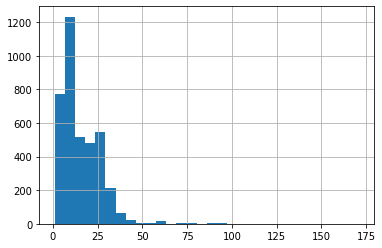

In [254]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30);

In [255]:
train_text

1188    All will come alive.better correct any good lo...
5403             So gd got free ice cream... I oso wan...
2924                     Are you coming to day for class.
880     Reminder: You have not downloaded the content ...
719     Macha dont feel upset.i can assume your mindse...
                              ...                        
5121                     Oops I did have it,  &lt;#&gt; ?
1006    Panasonic & BluetoothHdset FREE. Nokia FREE. M...
4374    Ur TONEXS subscription has been renewed and yo...
903     Lovely smell on this bus and it ain't tobacco... 
5057    Geeeee ... Your internet is really bad today, ...
Name: text, Length: 3900, dtype: object

In [256]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [257]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [258]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_token_ids = torch.tensor(tokens_train['token_type_ids'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_token_ids = torch.tensor(tokens_val['token_type_ids'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_token_ids = torch.tensor(tokens_test['token_type_ids'])
test_y = torch.tensor(test_labels.tolist())

In [259]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


# Check different pre-trained layers

In [260]:
for name, param in bert.named_parameters():
    print(f"layer name: {name}, require grad: {param.requires_grad}")

layer name: embeddings.word_embeddings.weight, require grad: True
layer name: embeddings.position_embeddings.weight, require grad: True
layer name: embeddings.token_type_embeddings.weight, require grad: True
layer name: embeddings.LayerNorm.weight, require grad: True
layer name: embeddings.LayerNorm.bias, require grad: True
layer name: encoder.layer.0.attention.self.query.weight, require grad: True
layer name: encoder.layer.0.attention.self.query.bias, require grad: True
layer name: encoder.layer.0.attention.self.key.weight, require grad: True
layer name: encoder.layer.0.attention.self.key.bias, require grad: True
layer name: encoder.layer.0.attention.self.value.weight, require grad: True
layer name: encoder.layer.0.attention.self.value.bias, require grad: True
layer name: encoder.layer.0.attention.output.dense.weight, require grad: True
layer name: encoder.layer.0.attention.output.dense.bias, require grad: True
layer name: encoder.layer.0.attention.output.LayerNorm.weight, require gra

# Weight Retraining and Finetuning

Note: All layers are set to `require grad: True` i.e trainable.

- Now we want to freeze upto layers 0 to 9
- retrain weights for layer 10 and 11

In [261]:
# freeze all the parameters except the last 1 layer
for name, param in bert.named_parameters():
    if 'layer.11' not in name and 'layer.10' not in name:
        param.requires_grad = False

In [262]:
for name, param in bert.named_parameters():
    print(f"layer name: {name}, require grad: {param.requires_grad}")

layer name: embeddings.word_embeddings.weight, require grad: False
layer name: embeddings.position_embeddings.weight, require grad: False
layer name: embeddings.token_type_embeddings.weight, require grad: False
layer name: embeddings.LayerNorm.weight, require grad: False
layer name: embeddings.LayerNorm.bias, require grad: False
layer name: encoder.layer.0.attention.self.query.weight, require grad: False
layer name: encoder.layer.0.attention.self.query.bias, require grad: False
layer name: encoder.layer.0.attention.self.key.weight, require grad: False
layer name: encoder.layer.0.attention.self.key.bias, require grad: False
layer name: encoder.layer.0.attention.self.value.weight, require grad: False
layer name: encoder.layer.0.attention.self.value.bias, require grad: False
layer name: encoder.layer.0.attention.output.dense.weight, require grad: False
layer name: encoder.layer.0.attention.output.dense.bias, require grad: False
layer name: encoder.layer.0.attention.output.LayerNorm.weight

# Design architecture

## Define model

In [263]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, token_type_ids):

      #pass the inputs to the model  
      z = self.bert(sent_id, attention_mask=mask, token_type_ids=token_type_ids)
      
      x = self.fc1(z[1])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [264]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

## Set optimizer

In [265]:
from transformers import AdamW

### Choose weight decay

In [266]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [267]:
optimizer = AdamW(optimizer_parameters, lr=3e-5)

In [268]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


## Define loss function

In [269]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 



## Train function

In [279]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('\t\t Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, token_type_ids, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask, token_type_ids)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


## Evaluate function

In [280]:
# function for evaluating the model
def evaluate():
  
  print("\t ++ Evaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('\t\t Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask,token_type_ids, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask, token_type_ids)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [281]:
from time import time

In [284]:
import numpy as np

# Train loop

In [285]:
# set initial loss to infinite
best_valid_loss = float('inf')

# number of training epochs
epochs = 3

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('=====> Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    start_time = time()
    #train model
    train_loss, _ = train()
    end_time = time()
    print(f"\t >> Training time taken: {np.round((end_time - start_time), 2)} seconds")

    #evaluate model

    start_time = time()
    valid_loss, _ = evaluate()
    end_time = time()
    print(f"\t >> Evaluation time taken: {np.round((end_time - start_time), 2)} seconds")

    
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\t >> Training Loss: {train_loss:.3f}')
    print(f'\t >> Validation Loss: {valid_loss:.3f}')


=====> Epoch 1 / 3
		 Batch    50  of    122.
		 Batch   100  of    122.
	 >> Training time taken: 7.9 seconds
	 ++ Evaluating...
	 >> Evaluation time taken: 1.21 seconds
	 >> Training Loss: 0.284
	 >> Validation Loss: 0.148
=====> Epoch 2 / 3
		 Batch    50  of    122.
		 Batch   100  of    122.
	 >> Training time taken: 7.88 seconds
	 ++ Evaluating...
	 >> Evaluation time taken: 1.23 seconds
	 >> Training Loss: 0.109
	 >> Validation Loss: 0.072
=====> Epoch 3 / 3
		 Batch    50  of    122.
		 Batch   100  of    122.
	 >> Training time taken: 7.93 seconds
	 ++ Evaluating...
	 >> Evaluation time taken: 1.25 seconds
	 >> Training Loss: 0.081
	 >> Validation Loss: 0.083


# Performance

In [286]:
%matplotlib inline
from matplotlib import pyplot as plt

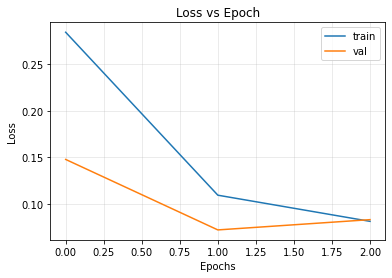

In [287]:
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="val")
plt.title("Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Prediction

In [288]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [290]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device), test_token_ids.to(device))
  preds = preds.detach().cpu().numpy()

In [291]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.92      0.95      0.93       112

    accuracy                           0.98       836
   macro avg       0.96      0.97      0.96       836
weighted avg       0.98      0.98      0.98       836



- Surprisingly the **second** finetuning approach (partial freezing of original architecture)has beaten the **third** approach (total freezing of entire network) as seen in the original blog, from where we have taken this example. Here is the reslt from the [blog site](https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/)

![image](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/07/bert_performance.png)